# Plot datasets

This notebook will visualize the data from diferent datasets (KuHar, MotionSense, and UCI-HAR). The data is without gravity and it was removed with a high-pass filter.

1. Apply DFT over dataset windows
3. Plot UMAP and T-SNE

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys
sys.path.append("../../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.har.loaders import (
    KuHar_BalancedView20HzMotionSenseEquivalent,
    MotionSense_BalancedView20HZ,
    ExtraSensorySense_UnbalancedView20HZ,
    CHARM_BalancedView20Hz,
    WISDM_UnbalancedView20Hz,
    UCIHAR_UnbalancedView20Hz
)
from librep.datasets.multimodal import PandasMultiModalDataset, TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.transforms. stats import StatsTransform
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-31 23:48:12.283715: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 23:48:12.283734: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Datasets to train the manifold

## Load KuHar

In [3]:
# Load KuHar, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = KuHar_BalancedView20HzMotionSenseEquivalent("../../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1", 
                              download=False)
train_val_kuhar = loader.load(concat_all=True, label="standard activity code")
train_val_kuhar

PandasMultiModalDataset: samples=3360, features=360, no. window=6, label_columns='standard activity code'

In [4]:
train_val_kuhar.data.iloc[:,:-10]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,-1.042828,7.069610,3.455672,0.858443,-13.806092,-5.950121,-0.608514,2.916913,4.881929,8.610287,...,-0.472805,0.343294,0.260441,-0.082865,0.299246,0.215924,0.322555,0.508903,-0.113054,-0.380190
1,-2.437900,-2.628449,-2.166861,-3.854701,0.527599,11.567884,6.840191,-2.435600,-3.324599,-0.796095,...,0.267483,-0.713088,0.337778,-0.016247,-0.170998,0.067450,-0.153206,-0.094137,-0.238300,0.377260
2,-0.664337,0.483465,3.090238,3.559119,3.888318,1.113559,3.656104,4.866379,0.073993,-14.136122,...,0.371043,0.478258,-0.547497,-0.010739,0.005712,-0.275884,0.048012,0.288451,0.118925,0.288595
3,-2.269775,-3.209509,-2.508545,-2.923223,-1.269270,7.864898,7.683389,2.325797,-3.086381,-3.675483,...,0.011855,0.110627,0.131676,0.085040,0.143971,0.129493,0.189543,0.057577,-0.121568,-0.037776
4,-0.487718,0.226401,0.609332,1.490074,-0.295221,-1.111420,-0.627382,0.028419,-0.823724,-0.469242,...,-0.224966,0.039142,-0.232840,0.027406,-0.153478,-0.047371,0.020793,0.186724,0.132858,0.318369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,-4.064457,0.710153,-0.210519,-0.085273,-0.689988,0.591841,0.208143,-0.555237,-2.460645,2.797614,...,-1.893353,-0.803982,3.908591,-1.889204,0.910382,-2.450892,2.668884,-0.594960,-0.777837,0.753996
3356,11.277711,7.928652,18.739669,1.170475,-16.387407,-6.588531,-9.052969,7.167498,28.822861,-2.055094,...,0.274248,1.729243,-0.830671,-2.122935,1.984299,0.268143,-0.511736,-0.081944,-1.253433,1.544963
3357,2.147823,-2.314857,-0.819528,-0.204672,-1.121992,-5.432771,4.140002,-1.748817,2.392677,0.545084,...,-0.705730,-1.000854,0.473762,0.187852,2.672917,-2.506846,-0.900893,0.936629,0.521924,0.856518
3358,-8.015342,2.348301,0.955636,1.112485,-3.618251,-3.723044,-0.024734,2.381249,3.211661,7.933797,...,-1.668099,-0.666467,-1.504154,4.529565,-2.584971,1.582942,-0.816463,1.323097,-2.078361,-2.053108


In [5]:
kuhar_X = train_val_kuhar.data.iloc[:,:-10]
kuhar_Y = train_val_kuhar.data['standard activity code']
tam = len(kuhar_Y)
kuhar_id_dataset = np.array(['K']*tam)

## Load MotionSense

In [6]:
loader = MotionSense_BalancedView20HZ("../../../data/views/MotionSense/balanced_20Hz_filtered", 
                                   download=False) 
train_val_motion = loader.load(concat_all=True, label="standard activity code")
train_val_motion

PandasMultiModalDataset: samples=5028, features=360, no. window=6, label_columns='standard activity code'

In [7]:
train_val_motion.data.iloc[:,540:-6]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,accel-z-50,accel-z-51,accel-z-52,accel-z-53,accel-z-54,accel-z-55,accel-z-56,accel-z-57,accel-z-58,accel-z-59
0,1.013198,1.213734,2.009169,-2.182658,-2.550637,-2.970507,-0.217632,0.999594,-1.246883,-1.457703,...,0.234732,0.376987,-2.081169,1.446188,-0.180460,-0.182989,0.666390,4.116260,-3.067699,-0.439384
1,3.468220,1.409920,-3.214915,-2.867658,-2.020174,1.271113,2.866810,3.731912,1.499058,-2.534589,...,-7.070344,-8.429237,-2.872219,1.445719,1.175976,1.904625,2.944915,2.950987,1.207228,0.922734
2,1.421498,0.017303,5.173924,-2.088614,-5.692213,-1.351758,3.589653,-0.080849,-0.191445,-0.111856,...,0.407130,1.247785,2.920146,1.520683,-1.583850,-1.367630,0.809506,1.110136,0.587751,5.467525
3,-0.497819,1.410787,-1.164364,0.479037,3.013279,-1.456027,1.731780,0.791390,1.319055,-0.111974,...,0.264238,0.378184,0.725342,0.523087,0.079355,0.776904,-1.858955,2.016718,0.997634,-1.641303
4,1.050593,-1.057788,-3.268201,-3.543602,-1.746914,3.277555,1.059173,2.462798,4.433639,-0.412389,...,4.262298,2.839317,-1.736072,5.396047,-0.261701,1.531596,-2.827182,3.128759,0.924363,-0.535934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,2.004535,2.609273,-0.777566,5.790095,4.359054,-4.121035,0.958092,-0.469032,4.947858,2.126789,...,0.126563,-0.919342,2.667698,7.049846,-3.420465,-5.633977,5.226585,5.615873,0.981034,-3.673905
5024,0.791806,1.613315,6.142404,-1.948661,0.721081,-7.445180,7.764421,-3.382841,-0.655162,-9.244234,...,5.364959,5.861080,-8.799775,-0.026598,8.373226,10.563284,-14.707570,4.514682,-3.539342,2.991253
5025,0.025046,0.818777,-9.129934,1.533859,3.172891,-0.118608,1.699464,2.342641,-5.414453,-4.136918,...,-0.403700,-11.571303,6.915320,10.663115,14.873362,-8.792862,-6.899139,-5.999598,-1.444385,-4.138246
5026,1.136342,0.959323,-0.002209,0.267273,-4.759702,2.358702,0.207890,-2.672748,-3.667548,-2.131495,...,-4.774496,-7.469756,17.803896,2.868205,-11.656172,4.414301,-8.503529,1.643911,-9.312668,1.771203


In [8]:
train_val_motion.data.iloc[:,360:540]

,gyro-x-0,gyro-x-1,gyro-x-2,gyro-x-3,gyro-x-4,gyro-x-5,gyro-x-6,gyro-x-7,gyro-x-8,gyro-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,2.416168,1.425987,0.432724,-0.442331,-1.008685,-0.968557,-1.727375,-0.785960,0.301713,-0.265985,...,-0.000940,0.192489,-0.019042,-0.486224,-0.136334,0.208895,0.523736,-0.763385,-0.543151,0.782424
1,-0.392869,0.680290,2.331535,2.825752,3.159755,0.603375,-1.526515,-1.490733,-2.338737,-2.199652,...,0.040037,-0.545322,-1.036972,-1.589284,-0.734425,-0.297475,-0.168993,1.026077,-0.110496,-0.984670
2,3.877532,1.026625,0.482123,0.281094,0.799710,-0.169250,-0.605498,-1.113426,-2.861108,-2.588045,...,0.680082,1.321175,1.452527,-0.171931,-0.036254,-0.526024,0.032629,-0.227881,-0.063752,0.299167
3,0.024890,0.100237,-0.765744,-0.135315,0.360571,1.073031,-0.325650,-0.951654,-0.412893,0.330772,...,0.462495,0.408306,0.067837,-0.175092,-0.132694,-0.127267,-0.038517,-0.349052,0.243316,0.035424
4,0.676135,-1.723360,-0.990657,-0.941559,0.313503,0.238453,-0.321289,-0.665136,0.447474,0.180847,...,-0.023703,0.183257,0.743221,0.550107,-0.560860,-0.092277,0.532015,0.227761,0.579212,0.218732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,-1.023721,-2.244999,-2.284888,-0.665339,0.025202,2.835075,3.173697,3.050147,1.327054,-0.045744,...,3.305324,2.149209,1.545474,-1.451223,-1.679996,0.619296,-0.576180,-3.000535,-2.343239,-2.079869
5024,0.462645,1.835205,-1.996374,-4.109942,-6.315888,-2.112793,-0.866276,2.483855,3.432113,5.302295,...,-0.513408,0.059170,-0.869835,1.418709,-0.333015,2.028773,1.078272,0.475017,-0.198779,-1.514206
5025,2.817022,3.871177,4.221806,2.749225,1.046050,-2.013996,-2.614715,-0.940133,2.111500,-1.088026,...,-0.248408,1.259049,-0.569404,-0.527184,-1.586541,-1.975594,-0.571789,-0.385179,0.536645,0.489831
5026,0.021670,-0.808959,-4.067501,-5.917265,-5.009484,-1.712742,2.579381,3.326548,5.654234,7.323675,...,-0.667787,0.185832,-0.737232,2.638622,1.365777,-0.041777,1.050452,-0.329185,1.534976,0.465610


In [9]:
motion_X = pd.concat([train_val_motion.data.iloc[:,540:-6], train_val_motion.data.iloc[:,360:540]], axis=1)
motion_Y = train_val_motion.data['standard activity code']
tam = len(motion_Y)
motion_id_dataset = np.array(['M']*tam)

In [10]:
motion_X

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,1.013198,1.213734,2.009169,-2.182658,-2.550637,-2.970507,-0.217632,0.999594,-1.246883,-1.457703,...,-0.000940,0.192489,-0.019042,-0.486224,-0.136334,0.208895,0.523736,-0.763385,-0.543151,0.782424
1,3.468220,1.409920,-3.214915,-2.867658,-2.020174,1.271113,2.866810,3.731912,1.499058,-2.534589,...,0.040037,-0.545322,-1.036972,-1.589284,-0.734425,-0.297475,-0.168993,1.026077,-0.110496,-0.984670
2,1.421498,0.017303,5.173924,-2.088614,-5.692213,-1.351758,3.589653,-0.080849,-0.191445,-0.111856,...,0.680082,1.321175,1.452527,-0.171931,-0.036254,-0.526024,0.032629,-0.227881,-0.063752,0.299167
3,-0.497819,1.410787,-1.164364,0.479037,3.013279,-1.456027,1.731780,0.791390,1.319055,-0.111974,...,0.462495,0.408306,0.067837,-0.175092,-0.132694,-0.127267,-0.038517,-0.349052,0.243316,0.035424
4,1.050593,-1.057788,-3.268201,-3.543602,-1.746914,3.277555,1.059173,2.462798,4.433639,-0.412389,...,-0.023703,0.183257,0.743221,0.550107,-0.560860,-0.092277,0.532015,0.227761,0.579212,0.218732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,2.004535,2.609273,-0.777566,5.790095,4.359054,-4.121035,0.958092,-0.469032,4.947858,2.126789,...,3.305324,2.149209,1.545474,-1.451223,-1.679996,0.619296,-0.576180,-3.000535,-2.343239,-2.079869
5024,0.791806,1.613315,6.142404,-1.948661,0.721081,-7.445180,7.764421,-3.382841,-0.655162,-9.244234,...,-0.513408,0.059170,-0.869835,1.418709,-0.333015,2.028773,1.078272,0.475017,-0.198779,-1.514206
5025,0.025046,0.818777,-9.129934,1.533859,3.172891,-0.118608,1.699464,2.342641,-5.414453,-4.136918,...,-0.248408,1.259049,-0.569404,-0.527184,-1.586541,-1.975594,-0.571789,-0.385179,0.536645,0.489831
5026,1.136342,0.959323,-0.002209,0.267273,-4.759702,2.358702,0.207890,-2.672748,-3.667548,-2.131495,...,-0.667787,0.185832,-0.737232,2.638622,1.365777,-0.041777,1.050452,-0.329185,1.534976,0.465610


## Load UCI-HAR

In [11]:
loader = UCIHAR_UnbalancedView20Hz("../../../data/views/UCI-HAR/balanced_20Hz_filtered", 
                                   download=False) 
train_val_uci = loader.load(concat_all=True, label="standard activity code")
train_val_uci

PandasMultiModalDataset: samples=2840, features=360, no. window=6, label_columns='standard activity code'

In [12]:
train_val_uci.data.iloc[:,:-3]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,0.156566,-1.424124,-2.905373,-1.449460,-1.068465,-1.123434,-1.195326,-0.833242,1.702248,2.030561,...,0.080595,-0.112580,0.156026,0.313386,0.000744,-0.047502,-0.569485,-0.652966,0.050269,0.477185
1,-0.537229,-0.186480,1.051567,0.605424,-0.185871,3.032825,4.907514,4.161293,1.228430,-0.243705,...,0.307554,0.768617,0.822427,0.841789,0.214277,-0.155207,-0.054555,0.275682,0.461437,-0.171866
2,-2.151572,-2.340571,0.602388,2.951933,1.112684,3.037523,-0.053386,-1.381455,-0.637672,-2.754747,...,0.239563,0.095893,0.056733,-0.278544,-0.050879,0.363474,0.356592,0.452005,0.304909,-0.237935
3,-0.121271,-1.496275,-1.492793,-1.547828,-0.905671,-0.681165,-0.371455,0.291828,1.207175,1.622875,...,-0.232457,-0.074255,0.416932,0.290052,0.337902,0.202508,-0.316462,-0.537158,-0.476181,-0.320307
4,1.557988,1.860748,1.597169,2.202641,3.586844,1.869756,-1.940422,-3.407308,-3.873758,-2.844197,...,-0.143105,0.161871,0.269892,0.205870,-0.161104,-0.067245,-0.006595,-0.044617,-0.235705,0.503788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835,-0.000958,-0.019664,0.026211,-0.001207,-0.037750,-0.038691,-0.020334,0.027428,-0.032307,-0.025282,...,0.004498,0.009185,0.004750,0.003225,0.007405,0.004294,0.003416,0.007763,0.007707,0.009001
2836,0.045167,-0.037133,-0.067926,0.139481,-0.016318,0.010556,0.019199,-0.015156,-0.062317,-0.172797,...,0.007017,-0.014896,-0.001919,0.003043,-0.021028,-0.013950,-0.064271,-0.085593,-0.067198,-0.029561
2837,-0.032533,-0.004799,-0.024588,-0.051822,0.042807,0.019523,-0.034658,-0.007025,0.006493,-0.001434,...,0.006820,0.004741,0.006743,0.002107,-0.001484,-0.000134,0.003454,-0.001465,-0.004153,-0.002858
2838,0.037385,-0.018655,0.003293,0.028780,0.009934,0.006147,0.007297,-0.013579,0.013963,-0.001217,...,0.007266,0.012989,0.011528,-0.001573,-0.001164,0.006791,0.007795,0.006621,-0.025012,-0.060256


In [13]:
uci_X = train_val_uci.data.iloc[:,:-3]
uci_Y = train_val_uci.data['standard activity code']

tam = len(uci_Y)
uci_id_dataset = np.array(['U']*tam)

## Concatenate datasets

## Prepare the test data

In [14]:
data_X = pd.concat([kuhar_X, motion_X, uci_X])
data_y = pd.concat([kuhar_Y, motion_Y, uci_Y])
data_id_dataset = np.concatenate([kuhar_id_dataset, motion_id_dataset, uci_id_dataset])

In [15]:
kuhar_X.shape, motion_X.shape, uci_X.shape

((3360, 360), (5028, 360), (2840, 360))

In [16]:
data = data_X
data['standard activity code'] = np.array(data_y)
data['DataSet'] = np.array(data_id_dataset)
data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,standard activity code,DataSet
0,-1.042828,7.069610,3.455672,0.858443,-13.806092,-5.950121,-0.608514,2.916913,4.881929,8.610287,...,0.260441,-0.082865,0.299246,0.215924,0.322555,0.508903,-0.113054,-0.380190,4,K
1,-2.437900,-2.628449,-2.166861,-3.854701,0.527599,11.567884,6.840191,-2.435600,-3.324599,-0.796095,...,0.337778,-0.016247,-0.170998,0.067450,-0.153206,-0.094137,-0.238300,0.377260,4,K
2,-0.664337,0.483465,3.090238,3.559119,3.888318,1.113559,3.656104,4.866379,0.073993,-14.136122,...,-0.547497,-0.010739,0.005712,-0.275884,0.048012,0.288451,0.118925,0.288595,4,K
3,-2.269775,-3.209509,-2.508545,-2.923223,-1.269270,7.864898,7.683389,2.325797,-3.086381,-3.675483,...,0.131676,0.085040,0.143971,0.129493,0.189543,0.057577,-0.121568,-0.037776,4,K
4,-0.487718,0.226401,0.609332,1.490074,-0.295221,-1.111420,-0.627382,0.028419,-0.823724,-0.469242,...,-0.232840,0.027406,-0.153478,-0.047371,0.020793,0.186724,0.132858,0.318369,4,K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835,-0.000958,-0.019664,0.026211,-0.001207,-0.037750,-0.038691,-0.020334,0.027428,-0.032307,-0.025282,...,0.004750,0.003225,0.007405,0.004294,0.003416,0.007763,0.007707,0.009001,1,U
2836,0.045167,-0.037133,-0.067926,0.139481,-0.016318,0.010556,0.019199,-0.015156,-0.062317,-0.172797,...,-0.001919,0.003043,-0.021028,-0.013950,-0.064271,-0.085593,-0.067198,-0.029561,1,U
2837,-0.032533,-0.004799,-0.024588,-0.051822,0.042807,0.019523,-0.034658,-0.007025,0.006493,-0.001434,...,0.006743,0.002107,-0.001484,-0.000134,0.003454,-0.001465,-0.004153,-0.002858,1,U
2838,0.037385,-0.018655,0.003293,0.028780,0.009934,0.006147,0.007297,-0.013579,0.013963,-0.001217,...,0.011528,-0.001573,-0.001164,0.006791,0.007795,0.006621,-0.025012,-0.060256,1,U


In [17]:
# Features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
data_dataset = PandasMultiModalDataset(
    data,
    feature_prefixes=features,
    label_columns="DataSet",
    as_array=True
)

# Test
data_activity = PandasMultiModalDataset(
    data,
    feature_prefixes=features,
    label_columns='standard activity code',
    as_array=True
)

In [18]:
# Create the objects

fft_transform = FFT(centered=True)

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], new_window_name_prefix="fft."
)

In [19]:
# Transform it and generate a new dataset!
data_dataset_fft = transformer(data_dataset)
data_activity_fft = transformer(data_activity)

In [20]:
# Checking the whole data...
data_dataset_fft[:][0]

array([[9.17338790e-01, 2.94403289e-01, 1.23462554e+00, ...,
        1.12933705e-01, 2.64129222e-01, 1.39964048e-01],
       [6.52337076e-01, 1.97729668e+00, 2.15721029e+00, ...,
        6.15419090e-02, 1.04666318e-01, 3.16286858e-01],
       [3.45508609e+00, 4.17256855e+00, 4.84083478e+00, ...,
        2.34285066e-01, 1.36510397e-01, 2.39903888e-01],
       ...,
       [2.42691610e-03, 3.43964553e-02, 4.66734264e-02, ...,
        4.59909347e-03, 3.71919407e-03, 2.85771067e-03],
       [2.25703063e-02, 3.60353279e-02, 2.46058901e-02, ...,
        7.31016425e-03, 3.56096950e-03, 5.85280730e-03],
       [1.34100669e-02, 2.26846021e-02, 1.63874660e-02, ...,
        1.96562894e-03, 1.41696867e-03, 1.97045550e-03]])

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [21]:
# # The reporter will be the same

# reporter = ClassificationReport(
#     use_accuracy=True,
#     use_f1_score=True,
#     use_classification_report=True,
#     use_confusion_matrix=True,
#     plot_confusion_matrix=True,
#     normalize='true'
# )

### RandomForest

In [22]:
# experiment = SimpleTrainEvalWorkflow(
#     estimator=RandomForestClassifier,
#     do_not_instantiate=False,
#     do_fit=True,
#     evaluator=reporter,
# )

# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)
# results = multi_run_experiment(train_val_fft, [test_fft])

# mean_acc = np.average(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# mean_f1 = np.average(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# print(f"Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")

### SVM

In [23]:
# experiment = SimpleTrainEvalWorkflow(
#     estimator=SVC,
#     do_not_instantiate=False,
#     do_fit=True,
#     evaluator=reporter,
# )

# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)
# results = multi_run_experiment(train_val_fft, [test_fft])

# mean_acc = np.average(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# mean_f1 = np.average(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# print(f"Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")

### KNN

In [24]:
# experiment = SimpleTrainEvalWorkflow(
#     estimator=KNeighborsClassifier,
#     do_not_instantiate=False,
#     do_fit=True,
#     evaluator=reporter,
# )

# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)
# results = multi_run_experiment(train_val_fft, [test_fft])

# mean_acc = np.average(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# mean_f1 = np.average(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# print(f"Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")

## Plot UMAP and T-SNE

In [25]:
def plot(df, figsize: tuple = (5, 5), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label, s=0.9)
    ax.legend()
    plt.title(title)
    plt.show()

In [26]:
labels_activity = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run"
}
classes = list(labels_activity.keys())
print(labels_activity)

{0: 'sit', 1: 'stand', 2: 'walk', 3: 'stair up', 4: 'stair down', 5: 'run'}


In [27]:
labels_dataset = {'K': 'KuHar', 
          'M': 'MotionSense',
          # 'C': 'CHARM',
          # 'E': 'ExtraSensory',
          # 'W': 'WISDM',
          'U': 'UCI',
         }

# KuHAR	K
# MotionSense	M
# CHARM	C
# ExtraSensory	E
# WISDM	W
# UCI	U

In [28]:
data_dataset.data.iloc[:,:-2]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,-1.042828,7.069610,3.455672,0.858443,-13.806092,-5.950121,-0.608514,2.916913,4.881929,8.610287,...,-0.472805,0.343294,0.260441,-0.082865,0.299246,0.215924,0.322555,0.508903,-0.113054,-0.380190
1,-2.437900,-2.628449,-2.166861,-3.854701,0.527599,11.567884,6.840191,-2.435600,-3.324599,-0.796095,...,0.267483,-0.713088,0.337778,-0.016247,-0.170998,0.067450,-0.153206,-0.094137,-0.238300,0.377260
2,-0.664337,0.483465,3.090238,3.559119,3.888318,1.113559,3.656104,4.866379,0.073993,-14.136122,...,0.371043,0.478258,-0.547497,-0.010739,0.005712,-0.275884,0.048012,0.288451,0.118925,0.288595
3,-2.269775,-3.209509,-2.508545,-2.923223,-1.269270,7.864898,7.683389,2.325797,-3.086381,-3.675483,...,0.011855,0.110627,0.131676,0.085040,0.143971,0.129493,0.189543,0.057577,-0.121568,-0.037776
4,-0.487718,0.226401,0.609332,1.490074,-0.295221,-1.111420,-0.627382,0.028419,-0.823724,-0.469242,...,-0.224966,0.039142,-0.232840,0.027406,-0.153478,-0.047371,0.020793,0.186724,0.132858,0.318369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835,-0.000958,-0.019664,0.026211,-0.001207,-0.037750,-0.038691,-0.020334,0.027428,-0.032307,-0.025282,...,0.004498,0.009185,0.004750,0.003225,0.007405,0.004294,0.003416,0.007763,0.007707,0.009001
2836,0.045167,-0.037133,-0.067926,0.139481,-0.016318,0.010556,0.019199,-0.015156,-0.062317,-0.172797,...,0.007017,-0.014896,-0.001919,0.003043,-0.021028,-0.013950,-0.064271,-0.085593,-0.067198,-0.029561
2837,-0.032533,-0.004799,-0.024588,-0.051822,0.042807,0.019523,-0.034658,-0.007025,0.006493,-0.001434,...,0.006820,0.004741,0.006743,0.002107,-0.001484,-0.000134,0.003454,-0.001465,-0.004153,-0.002858
2838,0.037385,-0.018655,0.003293,0.028780,0.009934,0.006147,0.007297,-0.013579,0.013963,-0.001217,...,0.007266,0.012989,0.011528,-0.001573,-0.001164,0.006791,0.007795,0.006621,-0.025012,-0.060256


In [29]:
def create_dataset(data, label_columns="standard activity code"):
    features = [
        "accel-x",
        "accel-y",
        "accel-z",
        "gyro-x",
        "gyro-y",
        "gyro-z"
    ]

    # Creating the datasets

    # Train
    data = PandasMultiModalDataset(
        data,
        feature_prefixes=features,
        label_columns=label_columns,
        as_array=True
    )
    return data

## UMAP

### Time

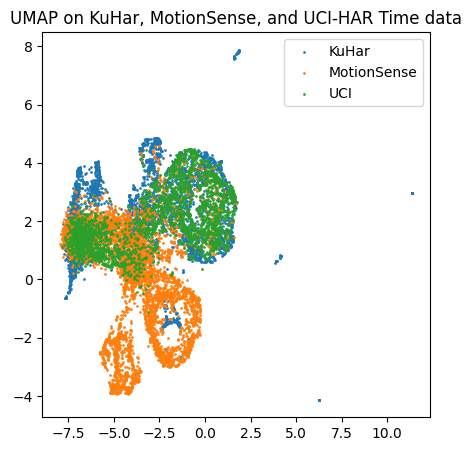

In [30]:
model = UMAP(n_components=2, random_state=42)
result = pd.DataFrame(model.fit_transform(np.array(data_dataset.data.iloc[:,:-2])), columns=["x", "y"])
result["label"] = np.array(data_dataset.data['DataSet'])
plot(result, title="UMAP on KuHar, MotionSense, and UCI-HAR Time data", labels = labels_dataset)

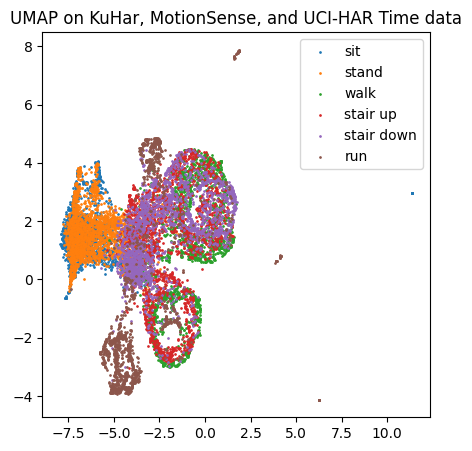

In [31]:
model = UMAP(n_components=2, random_state=42)
result = pd.DataFrame(model.fit_transform(np.array(data_dataset.data.iloc[:,:-2])), columns=["x", "y"])
result["label"] = np.array(data_dataset.data['standard activity code'])
plot(result, title="UMAP on KuHar, MotionSense, and UCI-HAR Time data", labels = labels_activity)

In [32]:
# new_data = data_activity.data[data_activity.data['standard activity code'].isin([0])]
# new_data.iloc[:,:-2]

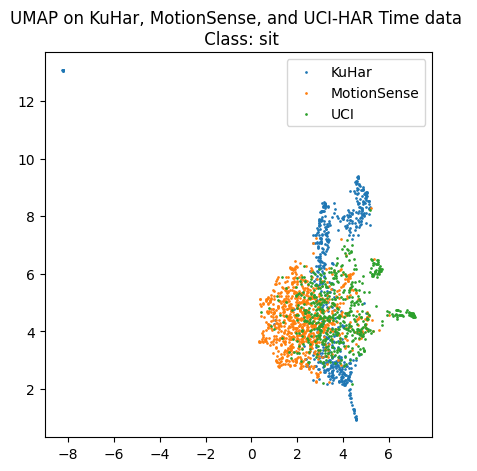

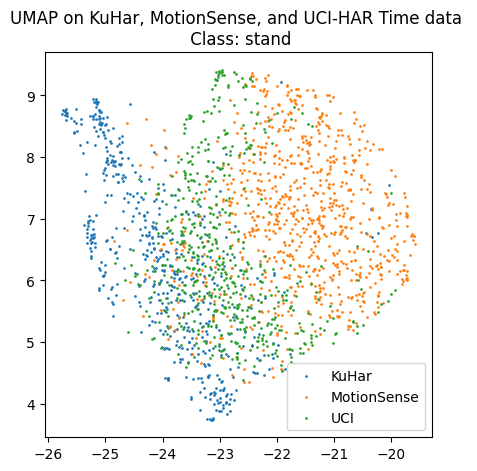

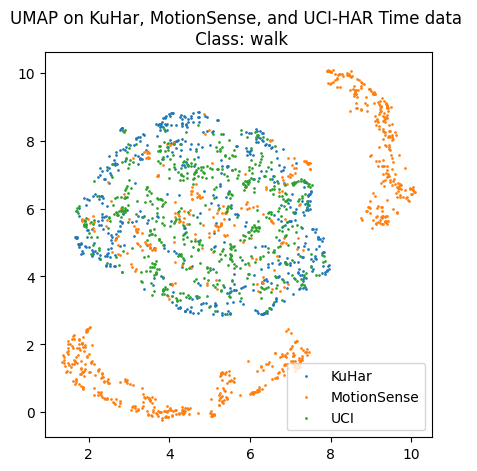

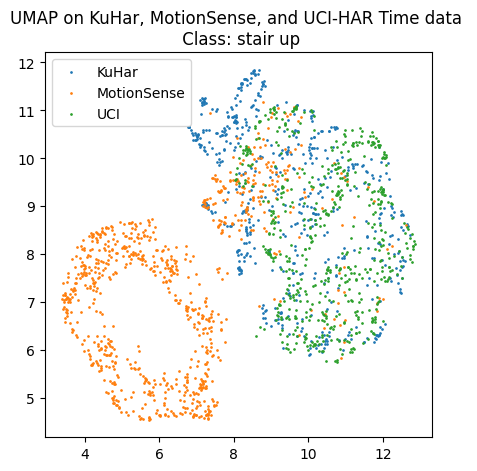

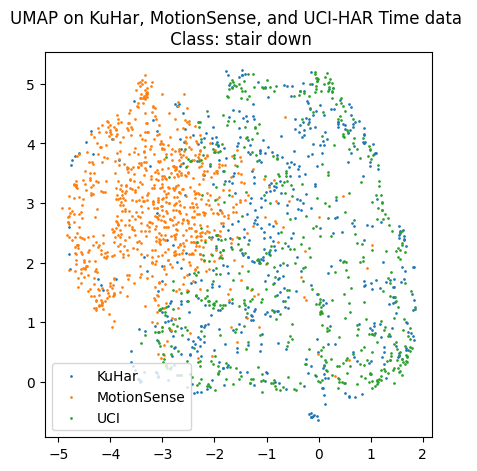

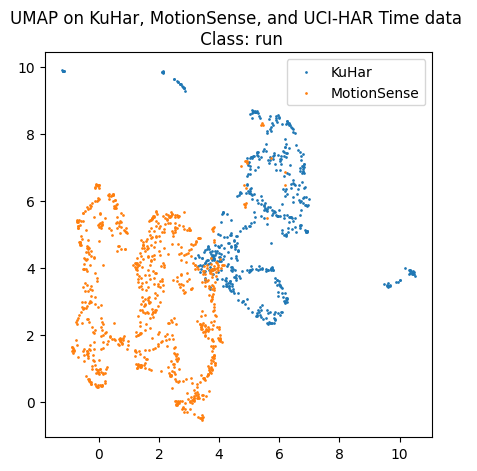

In [33]:
for i in classes:
    new_data = data_activity.data[data_activity.data['standard activity code'].isin([i])]
    model = UMAP(n_components=2, random_state=42)
    result = pd.DataFrame(model.fit_transform(np.array(new_data.iloc[:,:-2])), columns=["x", "y"])
    result["label"] = np.array(new_data['DataSet'])
    plot(result, title=f"UMAP on KuHar, MotionSense, and UCI-HAR Time data \n Class: {labels_activity[i]}", 
         labels = labels_dataset)

### Frequency

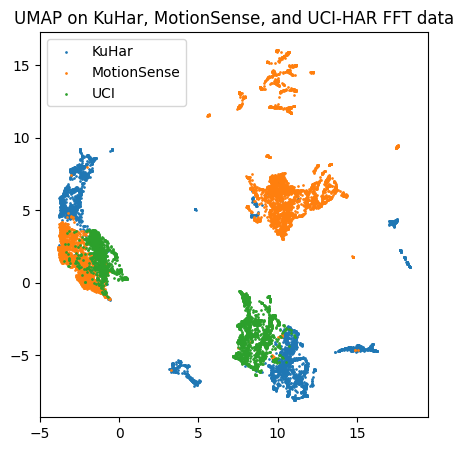

In [34]:
model = UMAP(n_components=2, random_state=42)
result = pd.DataFrame(model.fit_transform(data_dataset_fft[:][0]), columns=["x", "y"])
result["label"] = data_dataset_fft[:][1]
plot(result, title="UMAP on KuHar, MotionSense, and UCI-HAR FFT data", labels = labels_dataset)

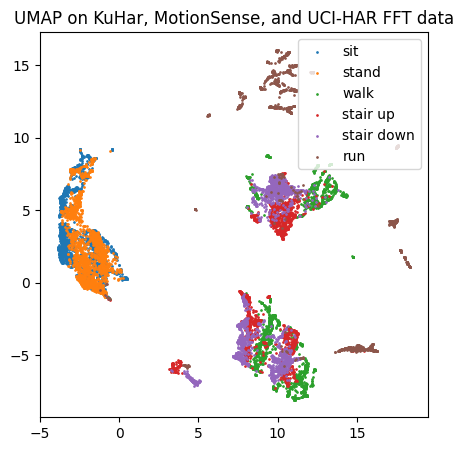

In [35]:
model = UMAP(n_components=2, random_state=42)
result = pd.DataFrame(model.fit_transform(data_activity_fft[:][0]), columns=["x", "y"])
result["label"] = data_activity_fft[:][1]
plot(result, title="UMAP on KuHar, MotionSense, and UCI-HAR FFT data", labels = labels_activity)

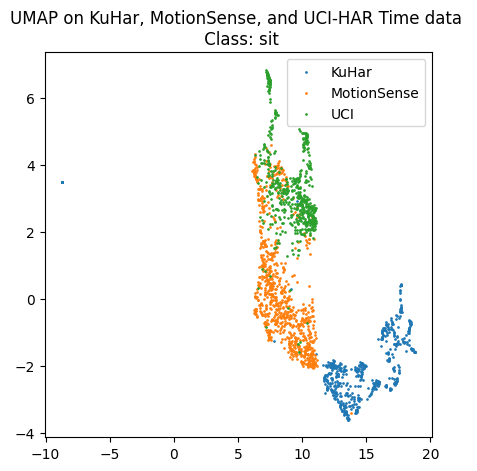

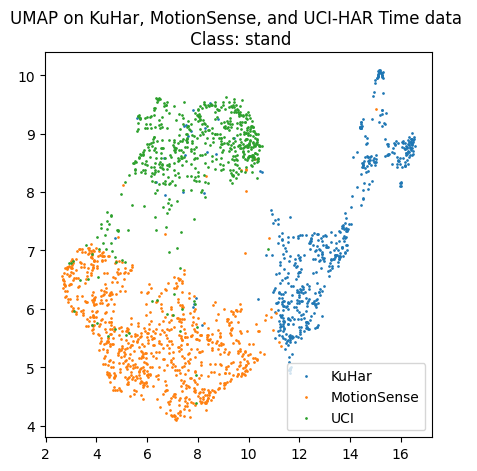

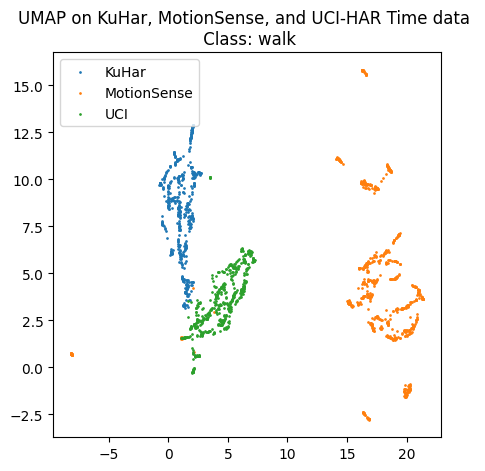

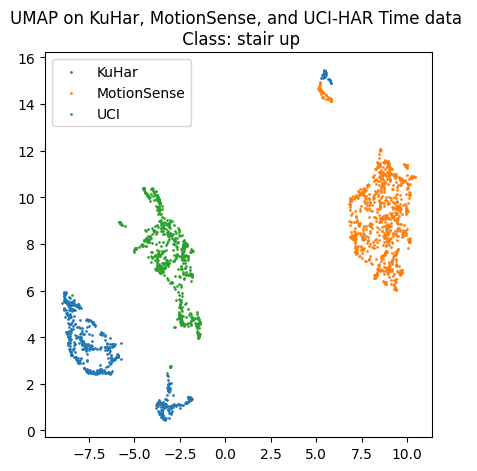

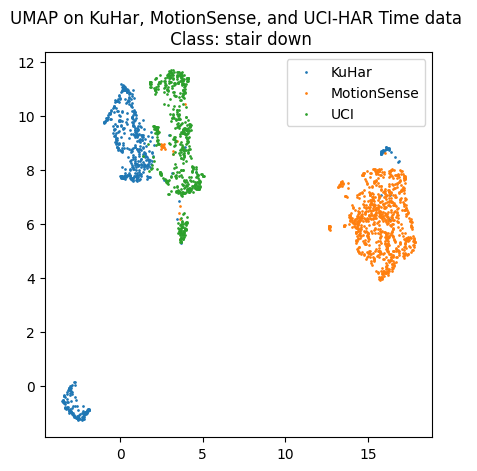

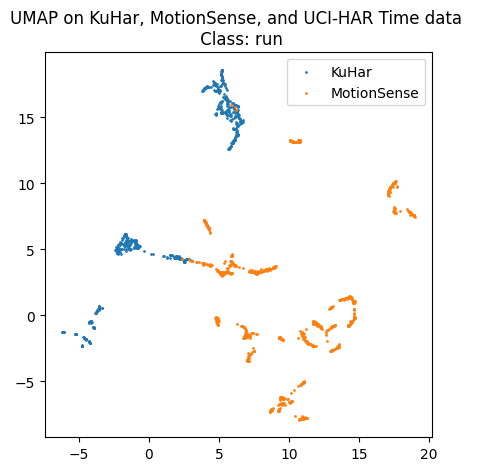

In [36]:
for i in classes:
    new_data = data_activity.data[data_activity.data['standard activity code'].isin([i])]
    new_data = create_dataset(new_data, label_columns="DataSet")
    new_data_fft = transformer(new_data)
    
    model = UMAP(n_components=2, random_state=42)
    result = pd.DataFrame(model.fit_transform(new_data_fft[:][0]), columns=["x", "y"])
    result["label"] = new_data_fft[:][1]
    plot(result, title=f"UMAP on KuHar, MotionSense, and UCI-HAR Time data \n Class: {labels_activity[i]}", 
         labels = labels_dataset)

## T-SNE

### Time

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


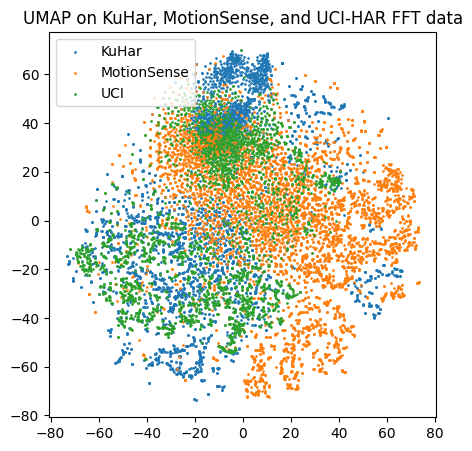

In [37]:
model = TSNE(n_components=2, random_state=42)
result = pd.DataFrame(model.fit_transform(np.array(data_dataset.data.iloc[:,:-2])), columns=["x", "y"])
result["label"] = np.array(data_dataset.data['DataSet'])
plot(result, title="UMAP on KuHar, MotionSense, and UCI-HAR FFT data", labels = labels_dataset)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


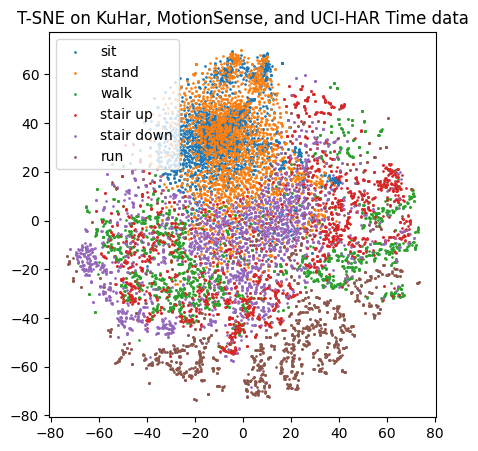

In [38]:
model = TSNE(n_components=2, random_state=42)
result = pd.DataFrame(model.fit_transform(np.array(data_dataset.data.iloc[:,:-2])), columns=["x", "y"])
result["label"] = np.array(data_dataset.data['standard activity code'])
plot(result, title="T-SNE on KuHar, MotionSense, and UCI-HAR Time data", labels = labels_activity)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


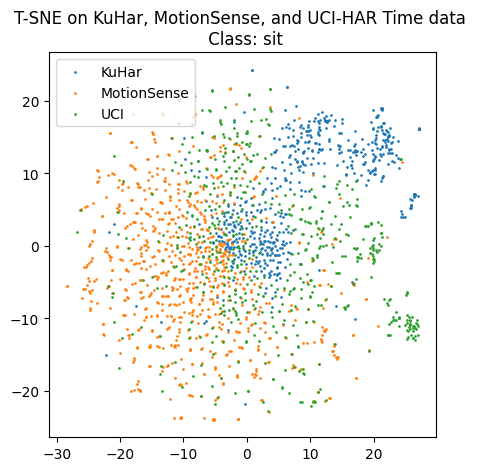

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


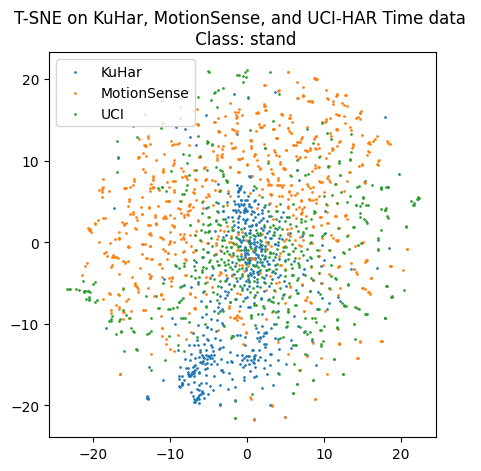

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


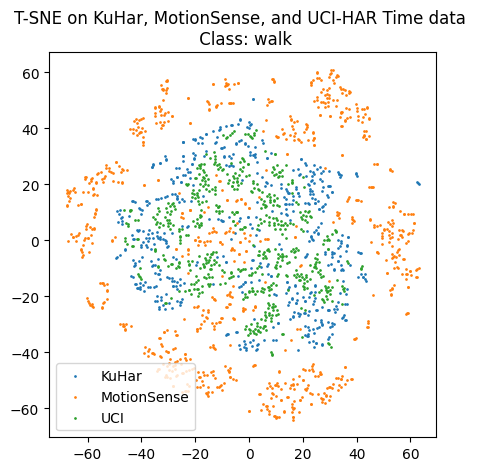

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


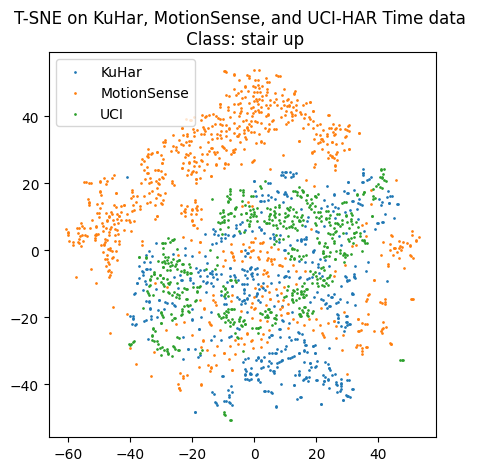

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


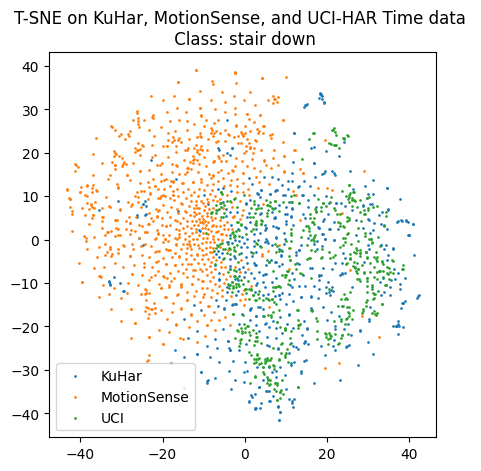

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


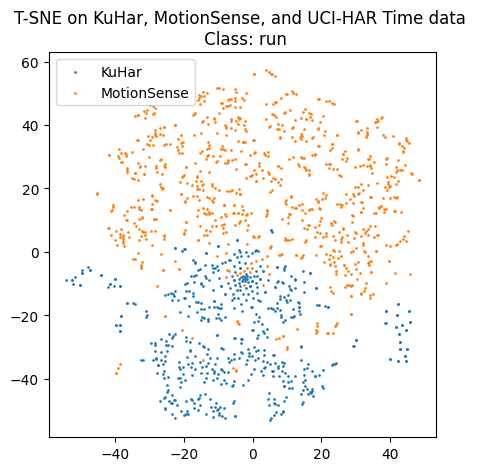

In [39]:
for i in classes:
    new_data = data_activity.data[data_activity.data['standard activity code'].isin([i])]
    model = TSNE(n_components=2, random_state=42)
    result = pd.DataFrame(model.fit_transform(np.array(new_data.iloc[:,:-2])), columns=["x", "y"])
    result["label"] = np.array(new_data['DataSet'])
    plot(result, title=f"T-SNE on KuHar, MotionSense, and UCI-HAR Time data \n Class: {labels_activity[i]}", 
         labels = labels_dataset)

### Frequency

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


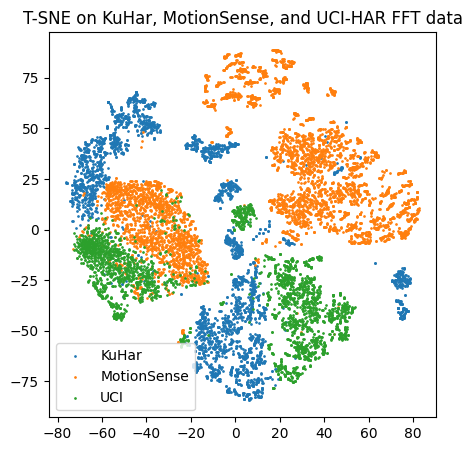

In [40]:
model = TSNE(n_components=2, random_state=42)
result = pd.DataFrame(model.fit_transform(data_dataset_fft[:][0]), columns=["x", "y"])
result["label"] = data_dataset_fft[:][1]
plot(result, title="T-SNE on KuHar, MotionSense, and UCI-HAR FFT data", labels = labels_dataset)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


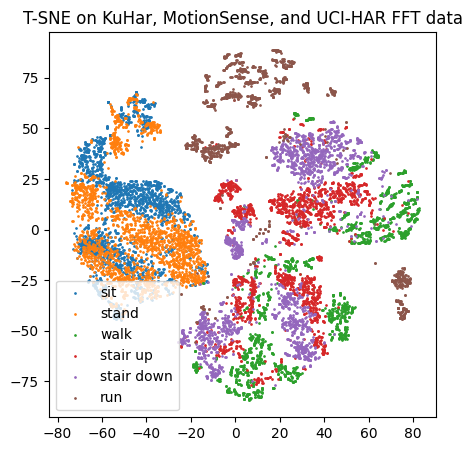

In [41]:
model = TSNE(n_components=2, random_state=42)
result = pd.DataFrame(model.fit_transform(data_activity_fft[:][0]), columns=["x", "y"])
result["label"] = data_activity_fft[:][1]
plot(result, title="T-SNE on KuHar, MotionSense, and UCI-HAR FFT data", labels = labels_activity)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


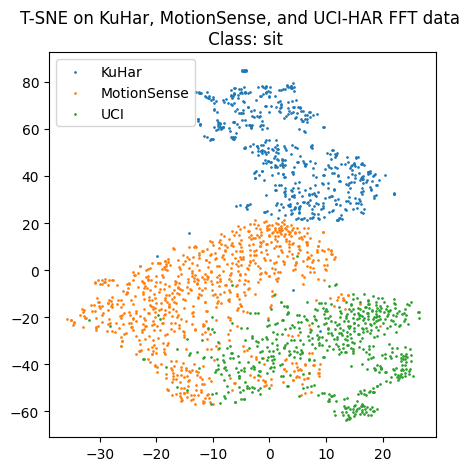

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


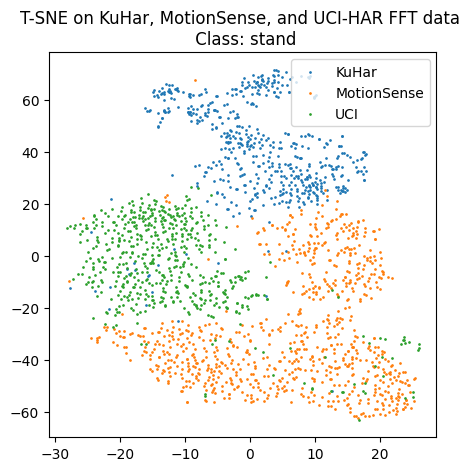

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


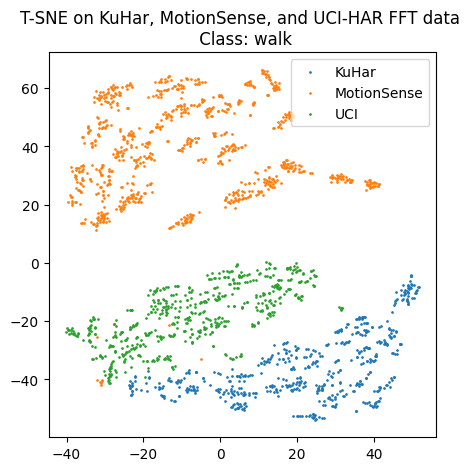

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


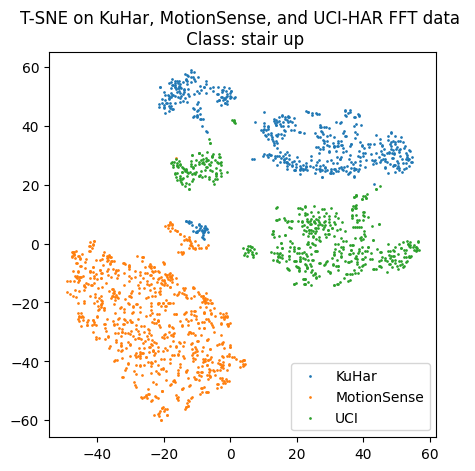

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


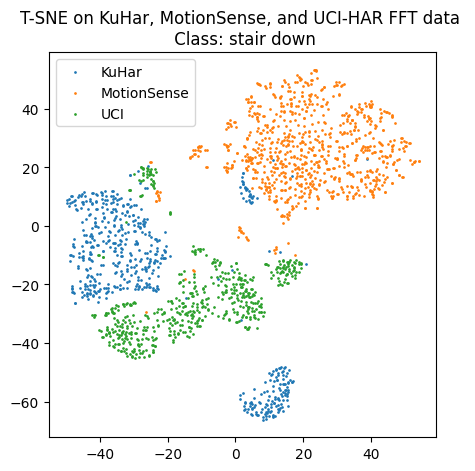

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


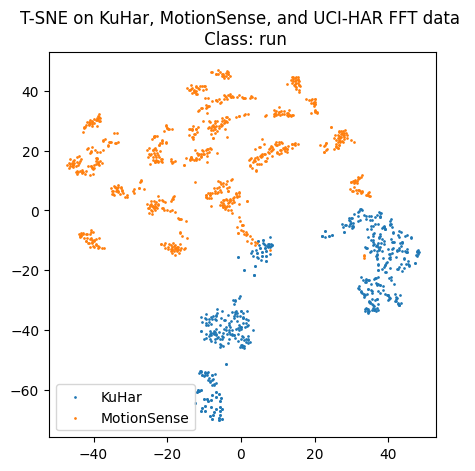

In [42]:
for i in classes:
    new_data = data_activity.data[data_activity.data['standard activity code'].isin([i])]
    new_data = create_dataset(new_data, label_columns="DataSet")
    new_data_fft = transformer(new_data)
    
    model = TSNE(n_components=2, random_state=42)
    result = pd.DataFrame(model.fit_transform(new_data_fft[:][0]), columns=["x", "y"])
    result["label"] = np.array(new_data_fft[:][1])
    plot(result, title=f"T-SNE on KuHar, MotionSense, and UCI-HAR FFT data \n Class: {labels_activity[i]}", 
         labels = labels_dataset)